# Digit Recognizer

This is a Kaggle competition based on the MNIST dataset, considered the "Hello World" dataset of computer vision, one of the most wildely used datasets to measure machine learning models.

The dataset contains handwritten images of digits, and I will try to build a model that recognizes this digits with a high precision. For this task I will use Convolutional Neural Networks, one of the best Deep Learning algorithms to recognize and understand images.

Lets start by importing the necessary functions:

In [1]:
import numpy as np
import pandas as pd
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


Loading our datasets as a Pandas dataframe:

In [2]:
train = pd.read_csv(r"C:\Users\juanv\Desktop\Programming\Machine Learning\Kaggle\Datasets\Digit recon\train.csv")
test= pd.read_csv(r"C:\Users\juanv\Desktop\Programming\Machine Learning\Kaggle\Datasets\Digit recon\test.csv")

## Data engineering

In [3]:
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Here we can see that each image is displayed as a values of pixels that range from 0 to 255 in only one channel (grey). Each row is an image, and each column represents a pixel except for the first one, "label" that contains the value of the digit represented in the image.

Checking for missing values on the train and the test dataset:

In [4]:
train.isnull().sum().describe()

count    785.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

In [5]:
test.isnull().sum().describe()

count    784.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

No missing values. So we can proceed to divide our dataset into the features our model will train on, and the target that our model will try to hit. In this case the features are the pixel values and the target is the "label" column that contains the value of the digit we are trying to guess.

We will call the features X_train, and the target Y_train.

In [6]:
Y_train = train['label']
X_train = train.drop('label',axis=1)


X_test = test

With that done now we need to reshape our data into an appropiate format for the Convolutional Neural Networks algorithm. That format is tipically: (number of images, rows, columns, channels) in our case channels will be set to 1 (grey images), in the typical RGB image channels would be set to 3.

First convert to a numpy array so we can reshape the data (pandas does not allow to reshape a dataframe so easily).

In [7]:
X_train = X_train.to_numpy()

X_test = test.to_numpy()

In [8]:
X_train = X_train.reshape(X_train.shape[0],28,28)

X_test = X_test.reshape(X_test.shape[0],28,28,1)

With that done lets take a look at the images on our data:

Number:0


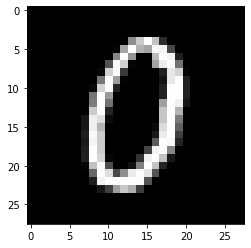

In [9]:
plt.imshow(X_train[5],cmap='gray', vmin=0, vmax=255)
print('Number:' + str(Y_train[5]))

### Normalization

Normalization is important so our model can converge faster on a data that ranges from 0 to 1 instead of 0 to 255.

It also reduces the effect of illumination differences.

In [11]:
X_train = X_train/255.0

X_test = X_test/255.0

### One hot enconding (label enconding)

We will also convert the values in our target array to a more clear categorical data, by a process called one hot enconding. One hot enconding makes sure that our model wont think that our target values are ordinal. (ex : 3 -> [0,0,0,1,0,0,0,0,0,0])

In [12]:
Y_train= to_categorical(Y_train)
Y_train.shape

(42000, 10)

### Splitting our data into train/validation 

We will use 90% of our data to train our model, meaning that our model will iterate on this data to learn a certain combinations of parameters to try and predict future images. To measure the accuracy of our model we will test it on a part of our data (10%) that wasnt used to train the model. The former dataset is called the training dataset, and the latter the validation dataset.

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=1)

In [14]:
X_train = X_train.reshape(X_train.shape[0],28,28,1)

X_train.shape

(37800, 28, 28, 1)

### Generating artificial images

The more data we have the more accurate will be our model. When we are lacking more data, and is not easy to find new data, one possible solution is to create this new data based on our old one. In our particular case we can generate some new images that will contain distortions, to simulate as accurate as possible the variations that happen when someone is writing a number.

In this case we will rotate a bit the images:

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

(37800, 28, 28, 1)

##  Neural Network Structure

Now that we are done messing with the data we will create our model.

**Details about the structure:** 

Filter size: I decided to use multiple convolutional layers with small filters, size of (3x3), since multiple stacked smaller size filters are better than one with a larger filter size, because multiple non-linear layers increases the depth of the network which enables it to learn more complex features.

Batch normalization: before each activation function to improve speed and performance. Batch normalization reduces the amount by what the hidden unit values shift around.

Zero padding: "pads" the edges of the data matrix so it doesnt shrink in size after each CONV layer

In [16]:
def DigitModel(input_shape):
    """
    Implementation of the model.
    
    Arguments:
    input_shape -- shape of the images of the dataset
        (height, width, channels) as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]
    """
    
    
     #Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((1, 1))(X_input)

    # CONV -> BN -> RELU Block 
    X = Conv2D(16, (3, 3), strides = (1, 1), name = 'conv0',padding='same')(X)
    X = BatchNormalization(axis = -1, name = 'bn0')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv1',padding='same')(X)
    X = BatchNormalization(axis = -1, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv2',padding='same')(X)
    X = BatchNormalization(axis = -1, name = 'bn2')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool0')(X)
    
    # CONV -> BN -> RELU Block
    X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv3',padding='same')(X)
    X = BatchNormalization(axis = -1, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(128, (3, 3), strides = (1, 1), name = 'conv4',padding='same')(X)
    X = BatchNormalization(axis = -1, name = 'bn4')(X)
    X = Activation('relu')(X)
    
    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool1')(X)

    # FLATTEN X (convert it to a vector) + FC layer
    X = Flatten()(X)
    X = Dense(512, activation='relu', name='fc0')(X)
    X = BatchNormalization(axis = -1, name = 'bn5')(X)
    X = Dense(10, activation='softmax', name='fc1')(X)

    # Create model.
    model = Model(inputs = X_input, outputs = X, name='DigitModel')

    return model

## Training

Lets proceed to train our model:

In [17]:
digit_model = DigitModel((28,28,1))

In [18]:
digit_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [19]:
digit_model.fit_generator(datagen.flow(X_train, Y_train, batch_size=16), epochs = 10)

Epoch 1/10
2363/2363 [==============================] - 32s 13ms/step - loss: 0.0350 - accuracy: 0.9879
Epoch 2/10
2363/2363 [==============================] - 29s 12ms/step - loss: 0.0174 - accuracy: 0.9942
Epoch 3/10
2363/2363 [==============================] - 30s 13ms/step - loss: 0.0134 - accuracy: 0.9954
Epoch 4/10
2363/2363 [==============================] - 32s 13ms/step - loss: 0.0119 - accuracy: 0.9960
Epoch 5/10
2363/2363 [==============================] - 32s 13ms/step - loss: 0.0105 - accuracy: 0.9966
Epoch 6/10
2363/2363 [==============================] - 30s 13ms/step - loss: 0.0094 - accuracy: 0.9969
Epoch 7/10
2363/2363 [==============================] - 30s 12ms/step - loss: 0.0081 - accuracy: 0.9973
Epoch 8/10
2363/2363 [==============================] - 30s 13ms/step - loss: 0.0080 - accuracy: 0.9974
Epoch 9/10
2363/2363 [==============================] - 31s 13ms/step - loss: 0.0079 - accuracy: 0.9974
Epoch 10/10
2363/2363 [==============================] - 29s 12m

## Validation 

Our model achieved an accuracy of 99.77% on our training data, lets check how it performs on the validation data, so we can make sure is not over-fitting (adjusting too much to our training data, but failing to generalize to new data it hasnt seen before)

In [21]:
X_val = X_val.reshape((X_val.shape[0],28,28,1))

preds = digit_model.evaluate(X_val, Y_val)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4200/4200 [==============================] - 1s 172us/step
Loss = 0.005318367086736197
Test Accuracy = 0.9980002641677856


Our model achieved an accuracy of 99.80% on our test data, so is not overfitting!

## Submit to Kaggle

Lets submit our models prediction to Kaggle to see how we score compared to others.

In [22]:
predictions = digit_model.predict(X_test, verbose=0)

predictions = predictions.argmax(axis=1)

submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("digit1.csv", index=False, header=True)

predictions

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

### 99.25% accuracy in Kaggle

Position 583 out of 2290 around submission time. Top 25%.

jvmd95